<a href="https://colab.research.google.com/github/BenLiu983/Disease-Image-Recognition-with-Deep-Learning/blob/main/0813_Operations_Department_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Understand the problem statement and business case

### Extensive X-Ray chest data has been collected. There are 133 images belonging to 4 classes: healthy, covid-19, bacterial pneumonia, viral pneumonia. The goal is to classify the images in an efficient manner. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Import the dataset

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Specify training data directory
XRay_Directory = '/content/drive/MyDrive/DS Projects/ds udemy/5 proj/disease diagnose/train'

In [4]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [7]:
# generate validation set
validation_generator = image_generator.flow_from_directory(batch_size=40, directory= XRay_Directory, shuffle=True,
                                                           target_size=(256,256), class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

In [12]:
# labels translator
label_names = {0: 'Covid-19', 1:'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# 3. Visualize the data

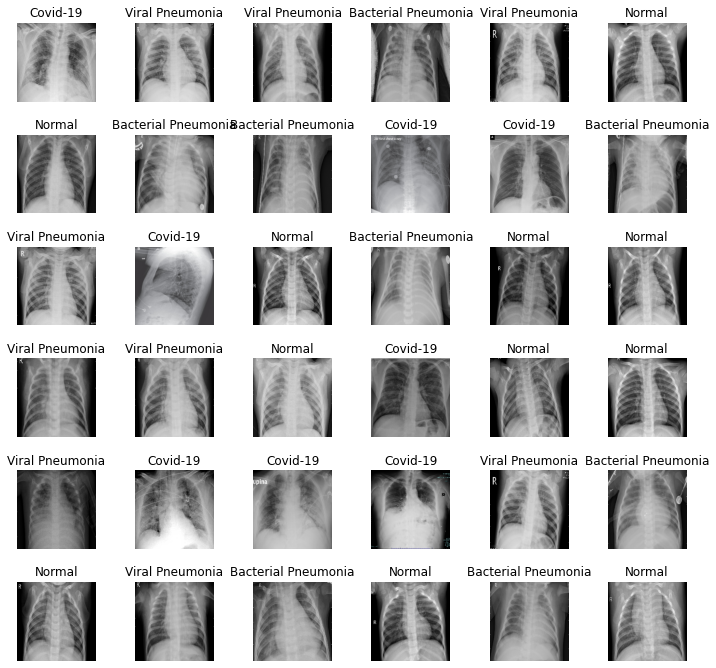

In [13]:
# create a grid of 36 images along with their labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# 4. Import model with pretrained weights

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
# freeze the model up to the last stage 4 and re-train stage 5
for layer in basemodel.layers[:-10]:
    layers.trainable = False

# 5. Build and train deep learning models.

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)


In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle = True, 
                                                      target_size=(256, 256), class_mode = 'categorical', subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4, directory=XRay_Directory, shuffle=True, 
                                                    target_size=(256, 256), class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, 
                              validation_data=val_generator, validation_steps = val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.6869
Epoch 1: val_loss improved from inf to 8.10835, saving model to weights.hdf5
107/107 [==============================] - 94s 668ms/step - loss: 0.8872 - accuracy: 0.6869 - val_loss: 8.1084 - val_accuracy: 0.2500
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8435
Epoch 2: val_loss did not improve from 8.10835
107/107 [==============================] - 14s 130ms/step - loss: 0.4227 - accuracy: 0.8435 - val_loss: 11.6815 - val_accuracy: 0.2500
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8902
Epoch 3: val_loss did not improve from 8.10835
107/107 [==============================] - 15s 140ms/step - loss: 0.3578 - accuracy: 0.8902 - val_loss: 51.7282 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9299
Epoch 4: val_loss did not improve from 8.

# 6. Evaluate trained deep learning model. 

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

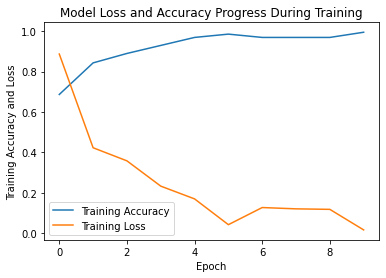

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])


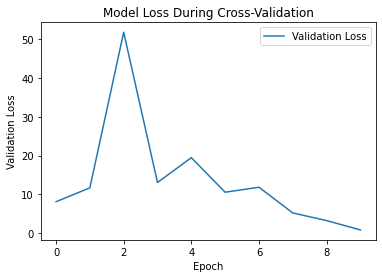

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

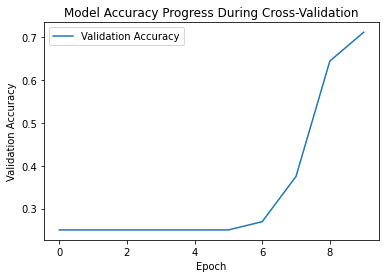

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

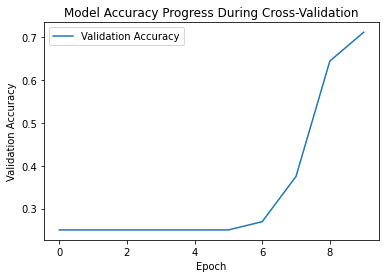

In [26]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [27]:
test_directory = '/content/drive/MyDrive/DS Projects/ds udemy/5 proj/disease diagnose/Test'

In [28]:
test_gen = ImageDataGenerator(rescale= 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, 
                                              shuffle= True, target_size= (256, 256), class_mode = 'categorical')
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose=1)

print('Accuracy Test : {}'.format(evaluate[1]))


Found 40 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


 1/10 [==>...........................] - ETA: 18s - loss: 1.0243 - accuracy: 0.7000

10/10 [==============================] - 2s 33ms/step - loss: 1.0243 - accuracy: 0.7000
Accuracy Test : 0.699999988079071


In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img/ 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)
        

In [30]:
len(original)

40

In [31]:
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.675


In [32]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.675


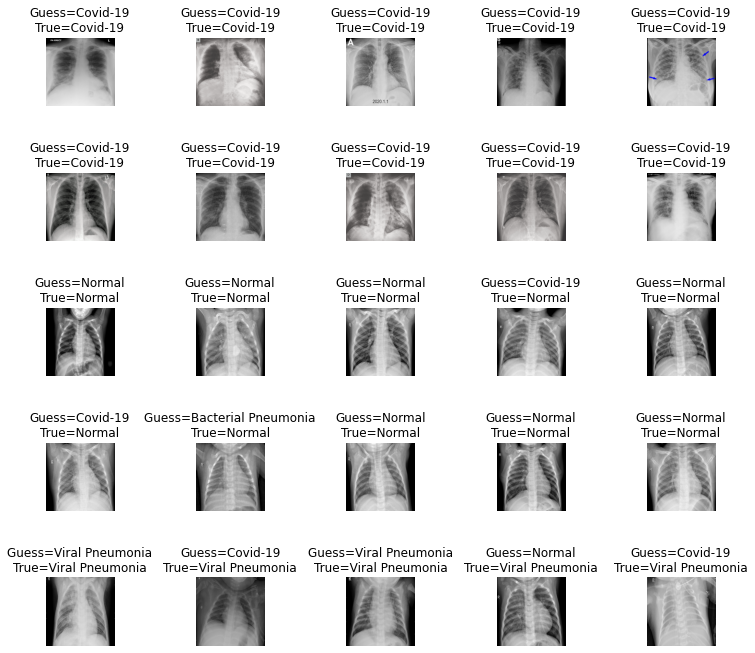

In [33]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [34]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.64      0.70      0.67        10
           2       1.00      0.50      0.67        10
           3       0.83      0.50      0.62        10

    accuracy                           0.68        40
   macro avg       0.76      0.68      0.67        40
weighted avg       0.76      0.68      0.67        40



Text(0.5, 1.0, 'Confusion_matrix')

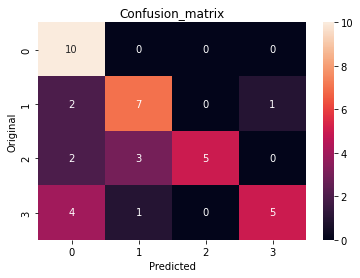

In [35]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')